# Analysing the factors of growth and spatial distribution of Airbnb properties across New York City

## Table of Contents
* [Introduction](#1) 
* [Necessary Imports](#117)
* [Accessing the Airbnb data as of 2019 and the NYC tracts dataset](#69) 
* [Visualizing dataset](#50) 
* [Aggregating Airbnb count by Tracts for NYC](#81)   
* [Importing demographic data using geoenrichment service](#133)  
* [Estimating distances of tracts from various city features](#347)   
* [Importing Borough Info for each Tract](#508)  
* [Merging all the above estimated data set of features](#504) 
* [Adding census data 2019 obtained using data enrich tool](#612)    
* [Model Building](#544)
    * [Random Forest Regressor Model](#643)  
    * [Feature importance of Random Forest model](#641) 
    * [Gradient Boosting Regressor Model](#645)   
    * [Feature Importance of Gradient Boosting Model](#647)   
* [Running cross validation](#651)
* [Result Visualization](#652)
* [Conclusion](#655)
* [Data resources](#656) 
* [Summary of methods used](#657)

## Introduction <a class="anchor" id="1"></a>


Airbnb properties across cities are a great alternative for travellers to find comparatively cheaper accommodation. It also provides homeowners opportunities to utilize spare or unused rooms as an additional income source. However in recent times the alarming spread of Airbnb properties has become a topic of debate among the public and the city authorities across the world.

Considering the above, a study is carried out in this sample notebook to understand the factors that are fuelling widespread growth in the number of Airbnb listings. These might include location characteristics of concerned neighbourhoods (which in this case, NYC census tracts) and as well as qualitative information about the inhabitants residing in them. The goal is to help city planners deal with the negative externalities of the Airbnb phenomenon (and similar short term rentals) by making informed decision on framing suitable policies. 

The primary data is downloaded from the [Airbnb website](http://insideairbnb.com/get-the-data.html) for the city of New York. Other data includes 2019 and 2017 census data using Esri's enrichment services, and various other datasets from the [NYCOpenData](https://opendata.cityofnewyork.us/) portal.

## Necessary Imports <a class="anchor" id="117"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.core.pylabtools import figsize
import seaborn as sns


# Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn import preprocessing

# Arcgis api imports
import arcgis
from arcgis.geoenrichment import Country
from arcgis.features import summarize_data
from arcgis.features.enrich_data import enrich_layer
from arcgis.features import SpatialDataFrame
from arcgis.features import use_proximity 
from arcgis.gis import GIS
from arcgis.features import summarize_data

In [2]:
gis = GIS('home')

### Access the NYC Airbnb and Tracts dataset <a class="anchor" id="69"></a>

Airbnb Data - It contains information about 48,000 Airbnb properties available in New York as of 2019. These include location of the property, its neighbourhood characters and transit facilities available, information about the owner, details of the room including number of bedrooms etc., and rental price per night.

NYC Tracts - It is a polygon shapefile consisting 2167 tracts of New York City, including area of the tracts along with unique id for each tract.
     

<Item title:"NYCTractData" type:Feature Layer Collection owner:api_data_owner>
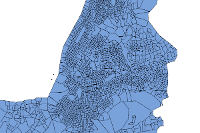

In [3]:
# Accessing NYCTracts
nyc_tract_full = gis.content.search('NYCTractData owner:api_data_owner', 'feature layer')[0]
nyc_tract_full

In [4]:
nyc_tracts_layer = nyc_tract_full.layers[0]

<Item title:"AnBNYC2019" type:Feature Layer Collection owner:api_data_owner>
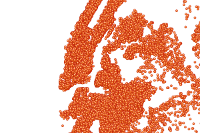

In [5]:
# Accessing airbnb NYC
airbnb_nyc2019 = gis.content.search('AnBNYC2019 owner:api_data_owner', 'feature layer')[0]
airbnb_nyc2019

In [6]:
airbnb_layer = airbnb_nyc2019.layers[0]

### Visualizing dataset <a class="anchor" id="50"></a>


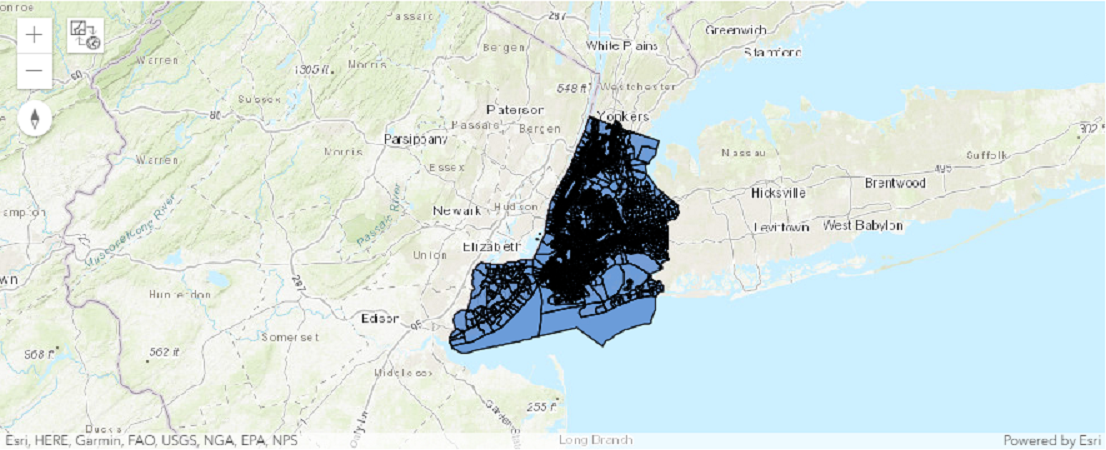

In [7]:
# NYC Tracts
m1 = gis.map('New York City')
m1.add_layer(nyc_tracts_layer)
m1


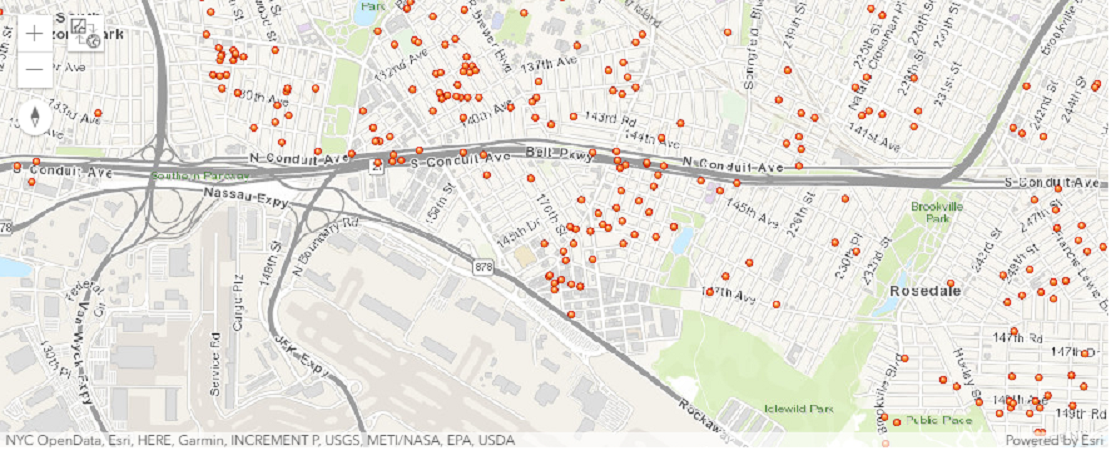

In [8]:
# NYC Airbnb Properties
m = gis.map('Springfield Gardens, NY')
m.add_layer(airbnb_layer)
m

In [9]:
# extracting the dataframe from the layer and visualize it as a pandas dataframe
pd.set_option('display.max_columns', 110)
sdf_airbnb_layer = pd.DataFrame.spatial.from_layer(airbnb_layer)
sdf_airbnb_layer.head(2)

,FID,SHAPE,access,accommodat,airbnb,amenities,availabi_1,availabi_2,availabi_3,availabili,bathrooms,bed_type,bedrooms,beds,calculat_1,calculat_2,calculat_3,calculated,calendar_l,calendar_u,cancellati,city,cleaning_f,country,country_co,descriptio,experience,extra_peop,first_revi,guests_inc,has_availa,host_accep,host_has_p,host_ident,host_is_su,host_listi,host_locat,host_neigh,host_res_1,host_respo,host_since,host_total,house_rule,id,instant_bo,interactio,is_busines,is_locatio,jurisdicti,last_revie,last_scrap,latitude,license,longitude,market,maximum__1,maximum_ma,maximum_mi,maximum_ni,minimum__1,minimum_ma,minimum_mi,minimum_ni,monthly_pr,name,neighborho,neighbou_1,neighbou_2,neighbourh,notes,number_of1,number_of_,price,property_t,require__1,require_gu,requires_l,review_s_1,review_s_2,review_s_3,review_s_4,review_s_5,review_s_6,review_sco,reviews_pe,room_type,scrape_id,security_d,smart_loca,space,square_fee,state,street,summary,transit,weekly_pri,zipcode
0,1,"{""x"": -8235507.210868829, ""y"": 4964733.1453062...",,4,1,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,0,0,0,2.0,Real Bed,2,2,1,1,0,2,2019-06-03,4 weeks ago,moderate,Brooklyn,$60.00,United States,US,"Imagine a quiet, spacious apartment, with beau...",none,$0.00,2011-05-29,2,t,N/A,t,t,t,2,"New York, New York, United States",Park Slope,100%,within a day,2011-05-22,2,"No pets, no smoking. The $25/night for each gu...",121861,f,,f,t,,2016-05-02,2019-06-03,40.67644,,-73.98082,New York,730.0,730,2,730,2.0,730,2,2,,"Park Slope Apt:, Spacious 2 bedroom",,Park Slope,Brooklyn,Brooklyn,,0,23,165,Apartment,f,f,f,10,10,10,10,10,10,99,0.24,Entire home/apt,20200000000000,$250.00,"Brooklyn, NY","Imagine a quiet, spacious apartment, with beau...",1500,NY,"Brooklyn, NY, United States",,,"$1,050.00",11215
1,2,"{""x"": -8231847.026011546, ""y"": 4983593.6741002...",Everything in the studio is for their use.,3,1,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Paid p...",28,43,296,8,1.0,Real Bed,0,2,1,1,0,2,2019-06-03,7 months ago,strict_14_with_grace_period,New York,$60.00,United States,US,"Comfortable, spacious studio in one of the mos...",none,$25.00,2011-05-30,1,t,N/A,t,f,f,2,"New York, New York, United States",Harlem,100%,within an hour,2011-05-23,2,no loud music no pets no children $300 dollar...,123784,t,As much as the guest would like.,f,t,,2019-05-17,2019-06-03,40.80481,,-73.94794,New York,365.0,365,2,365,2.0,365,2,2,"$3,200.00",NYC Studio for Rent in Townhouse,"The new restaurants, stores and cafes. Everyth...",Harlem,Manhattan,Harlem,45.00 dollar fee for air-conditioner in the su...,42,138,110,Apartment,t,t,f,10,9,10,10,10,9,94,1.41,Entire home/apt,20200000000000,$500.00,"New York, NY",This is a large studio room with a private bat...,0,NY,"New York, NY, United States","Comfortable, spacious studio in one of the mos...",,$735.00,10027


### Aggregating number of Airbnb properties by Tracts for NYC <a class="anchor" id="81"></a>
Number of Airbnb properties per tract is to be estimated using the polygon tract layer and the Airbnb point layer.

The Aggregate Points tool uses area features to summarize a set of point features. The boundaries from the area feature are used to collect the points within each area and use them to calculate statistics. The resulting layer displays the count of points within each area. Here, the polygon tract layer is used as the area feature, and the Airbnb point layer is used as the point feature.

In [10]:
agg_result = summarize_data.aggregate_points(point_layer=airbnb_layer,
                                             polygon_layer=nyc_tracts_layer,
                                             output_name='airbnb_counts'+ str(datetime.now().microsecond))

In [11]:
agg_result

<Item title:"airbnb_counts748780" type:Feature Layer Collection owner:arcgis_python>


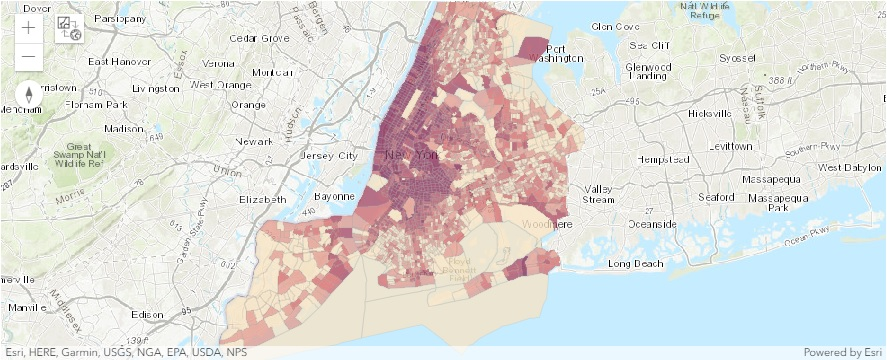

In [12]:
# mapping the aggregated airbnb data with darker areas showing more airbnb properties per tract
aggr_map = gis.map('NY', zoomlevel=10)
aggr_map.add_layer(agg_result,{"renderer":"ClassedColorRenderer", "field_name": "Point_Count"})
aggr_map

In [13]:
airbnb_count_by_tract = agg_result.layers[0]

In [14]:
sdf_airbnb_count_by_tract = airbnb_count_by_tract.query().sdf

In [15]:
sdf_airbnb_count_by_tract = sdf_airbnb_count_by_tract.sort_values('geoid')
sdf_airbnb_count_by_tract.head()

,AnalysisArea,OBJECTID,Point_Count,SHAPE,Shape__Area,Shape__Length,aland,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,statefp,tractce
2095,1.044430,2096,0,"{""rings"": [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,1579361,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,36,000100
2059,0.533681,2060,0,"{""rings"": [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,455322,926899,005,S,36005000200,+40.8045733,-073.8568585,G5020,2,Census Tract 2,36,000200
2067,0.585075,2068,15,"{""rings"": [[[-8222012.885, 4985135.2266], [-82...",2.647647e+06,8312.955974,912392,602945,005,S,36005000400,+40.8089152,-073.8504884,G5020,4,Census Tract 4,36,000400
1668,0.187289,1669,1,"{""rings"": [[[-8222181.7567, 4986069.1354], [-8...",8.478126e+05,3898.163149,485079,0,005,S,36005001600,+40.8188478,-073.8580764,G5020,16,Census Tract 16,36,001600
2127,1.074650,2128,24,"{""rings"": [[[-8230028.8927, 4984061.5402], [-8...",4.862123e+06,11742.631147,1643654,1139660,005,S,36005001900,+40.8009990,-073.9093729,G5020,19,Census Tract 19,36,001900


Here the Point_Count field from the above aggregated dataframe returns the number of Airbnb properties per tract. This would form the target variable for this problem.

### Enriching tracts with demographic data using geoenrichment service from Esri <a class="anchor" id="133"></a>
The feature data is now created using selected demographics information for each tracts. This is accomplished accessing the geoenrichment services from Esri, which consists the latest census data. The entire data repository is first visualized, out of which the relevant variables are finalized from a literature study. These selected variables are searched for adding in the feature set.

In [16]:
# Displaying the various data topic available for geoenrichment for USA in the Esri database
usa = Country.get('US')
type(usa)
usa_data = usa.data_collections
df_usa_data = pd.DataFrame(usa_data)
df_usa_data.head()

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2019 Population Age <1,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE1_CY,2019 Population Age 1,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE2_CY,2019 Population Age 2,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE3_CY,2019 Population Age 3,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE4_CY,2019 Population Age 4,2019 Age: 1 Year Increments (Esri),2019


All the data topics are visualized that are available in the geoenrichment services.

In [17]:
# Filtering the unique topic under dataCollectionID
df_usa_data.reset_index(inplace=True)
list(df_usa_data.dataCollectionID.unique())

['1yearincrements',
 '5yearincrements',
 'ACS_Housing_Summary_rep',
 'ACS_Population_Summary_rep',
 'Age',
 'AgeDependency',
 'Age_50_Profile_rep',
 'Age_by_Sex_Profile_rep',
 'Age_by_Sex_by_Race_Profile_rep',
 'AtRisk',
 'AutomobilesAutomotiveProducts',
 'Automotive_Aftermarket_Expenditures_rep',
 'BabyProductsToysGames',
 'Business_Summary_rep',
 'CivicActivitiesPoliticalAffiliation',
 'ClothingShoesAccessories',
 'Community_Profile_rep',
 'DaytimePopulation',
 'Demographic_and_Income_Comparison_Profile_rep',
 'Demographic_and_Income_Profile_rep',
 'Disposable_Income_Profile_rep',
 'ElectronicsInternet',
 'Electronics_and_Internet_Market_Potential_rep',
 'Executive_Summary_rep',
 'Finances_Market_Potential_rep',
 'FinancialInsurance',
 'Financial_Expenditures_rep',
 'Generations',
 'Graphic_Profile_rep',
 'GroceryAlcoholicBeverages',
 'Health',
 'HealthPersonalCare',
 'HealthPersonalCareCEX',
 'Health_and_Beauty_Market_Potential_rep',
 'HistoricalHouseholds',
 'HistoricalHousing',
 '

Items can be searched using alias field, for the related analysis variable name --  here as an example a variable with 'Nonprofit' is searched. Out of the these the relevant 'Nonprofit' data is to be selected.

In [18]:
df_usa_data[df_usa_data['alias'].str.contains('Nonprofit')]                        

,dataCollectionID,analysisVariable,alias,fieldCategory,vintage
10587,classofworker,classofworker.ACSMPRIVNP,ACS Civ Emp Male 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017
10588,classofworker,classofworker.MOEMPRIVNP,MOE Civ Emp Male 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017
10595,classofworker,classofworker.RELMPRIVNP,REL Civ Emp Male 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017
10620,classofworker,classofworker.ACSFPRIVNP,ACS Civ Emp Female 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017
10621,classofworker,classofworker.MOEFPRIVNP,MOE Civ Emp Female 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017
10622,classofworker,classofworker.RELFPRIVNP,REL Civ Emp Female 16+:Priv Nonprofit,2013-2017 Civilian Population 16+ by Class of ...,2013-2017


Adding data using enrichment - At this stage a literature study is undertaken to narrow down the various factors that might impact opening of new Airbnb properties in NYC. 

Subsequently these factors are identified from the USA geoenrichment database as shown above. These variable names are then compiled in a dictionary for passing them to the enrichment tool.

In [19]:
enrichment_variables = {'classofworker.ACSCIVEMP':      'Employed Population Age 16+',
 'classofworker.ACSMCIVEMP':                      'Employed Male Pop Age 16+',
 'classofworker.ACSMPRIVNP':                      'Male 16+Priv Nonprofit',
 'classofworker.ACSMEPRIVP':                      'Male 16+:Priv Profit Empl',
 'classofworker.ACSMSELFI':                       'Male 16+:Priv Profit Self Empl',
 'classofworker.ACSMSTGOV':                       'Male 16+:State Govt Wrkr',
 'classofworker.ACSMFEDGOV':                      'Male 16+:Fed Govt Wrkr',
 'classofworker.ACSMSELFNI':                      'Male 16+:Self-Emp Not Inc',
 'classofworker.ACSMUNPDFM':                      'Male 16+:Unpaid Family Wrkr',              
 'classofworker.ACSFCIVEMP':                      'Female Pop Age 16+',
 'classofworker.ACSFEPRIVP':                      'Female 16+:Priv Profit Empl',
 'classofworker.ACSFSELFI':                       'Female 16+:Priv Profit Self Empl',                      
 'classofworker.ACSFPRIVNP':                      'Female 16+:Priv Nonprofit',
 'classofworker.ACSFLOCGOV':                      'Female 16+:Local Govt Wrkr',
 'classofworker.ACSFSTGOV':                       'Female 16+:State Govt Wrkr',
 'classofworker.ACSFFEDGOV':                      'Female 16+:Fed Govt Wrkr',                      
 'classofworker.ACSFSELFNI':                      'Female 16+:Self-Emp Not Inc',                      
 'classofworker.ACSFUNPDFM':                      'Female 16+:Unpaid Family Wrkr',                      
 'gender.MEDAGE_CY':                              '2019 Median Age',
 'Generations.GENALPHACY':                        '2019 Generation Alpha Population',
 'Generations.GENZ_CY':                           '2019 Generation Z Population',
 'Generations.MILLENN_CY':                        '2019 Millennial Population',
 'Generations.GENX_CY':                           '2019 Generation X Population',
 'Generations.BABYBOOMCY':                        '2019 Baby Boomer Population',
 'Generations.OLDRGENSCY':                        '2019 Silent & Greatest Generations Population',
 'Generations.GENBASE_CY':                        '2019 Population by Generation Base',
 'populationtotals.POPDENS_CY':                   '2019 Population Density',
 'DaytimePopulation.DPOP_CY':                     '2019 Total Daytime Population',
 'raceandhispanicorigin.WHITE_CY':                '2019 White Population',
 'raceandhispanicorigin.BLACK_CY':                '2019 Black Population',
 'raceandhispanicorigin.AMERIND_CY':              '2019 American Indian Population',
 'raceandhispanicorigin.ASIAN_CY':                '2019 Asian Population',
 'raceandhispanicorigin.PACIFIC_CY':              '2019 Pacific Islander Population',
 'raceandhispanicorigin.OTHRACE_CY':              '2019 Other Race Population',
 'raceandhispanicorigin.DIVINDX_CY':              '2019 Diversity Index',
 'households.ACSHHBPOV':                          'HHs: Inc Below Poverty Level',
 'households.ACSHHAPOV':                          'HHs:Inc at/Above Poverty Level',
 'households.ACSFAMHH':                           'ACS Family Households',
 'businesses.S01_BUS':                            'Total Businesses (SIC)',
 'businesses.N05_BUS':                            'Construction Businesses (NAICS)',
 'businesses.N08_BUS':                            'Retail Trade Businesses (NAICS)',
 'businesses.N21_BUS':                            'Transportation/Warehouse Bus (NAICS)',
 'ElectronicsInternet.MP09147a_B':                'Own any tablet',
 'ElectronicsInternet.MP09148a_B':                'Own any e-reader',
 'ElectronicsInternet.MP19001a_B':                'Have access to Internet at home',                
 'ElectronicsInternet.MP19070a_I':                'Index: Spend 0.5-0.9 hrs online(excl email/IM .',               
 'ElectronicsInternet.MP19071a_B':                'Spend <0.5 hrs online (excl email/IM time) daily',
 'populationtotals.TOTPOP_CY':                    '2019 Total Population',              
 'gender.MALES_CY':                               '2019 Male Population',
 'gender.FEMALES_CY':                             '2019 Female Population',
 'industry.EMP_CY':                               '2019 Employed Civilian Pop 16+',
 'industry.UNEMP_CY':                             '2019 Unemployed Population 16+',                     
 'industry.UNEMPRT_CY':                           '2019 Unemployment Rate',
 'commute.ACSWORKERS':                            'ACS Workers Age 16+',
 'commute.ACSDRALONE':                            'ACS Workers 16+: Drove Alone',
 'commute.ACSCARPOOL':                            'ACS Workers 16+: Carpooled',
 'commute.ACSPUBTRAN':                            'ACS Workers 16+: Public Transportation',
 'commute.ACSBUS':                                'ACS Workers 16+: Bus',
 'commute.ACSSTRTCAR':                            'ACS Workers 16+: Streetcar',
 'commute.ACSSUBWAY':                             'ACS Workers 16+: Subway',
 'commute.ACSRAILRD':                             'ACS Workers 16+: Railroad',
 'commute.ACSFERRY':                              'ACS Workers 16+: Ferryboat',
 'commute.ACSTAXICAB':                            'ACS Workers 16+: Taxicab',           
 'commute.ACSMCYCLE':                             'ACS Workers 16+: Motorcycle',
 'commute.ACSBICYCLE':                            'ACS Workers 16+: Bicycle',                             
 'commute.ACSWALKED':                             'ACS Workers 16+: Walked',
 'commute.ACSOTHTRAN':                            'ACS Workers 16+: Other Means',
 'commute.ACSWRKHOME':                            'ACS Wrkrs 16+: Worked at Home',
 'OwnerRenter.OWNER_CY':                          '2019 Owner Occupied HUs', 
 'OwnerRenter.RENTER_CY':                         '2019 Renter Occupied HUs', 
 'vacant.VACANT_CY':                              '2019 Vacant Housing Units', 
 'homevalue.MEDVAL_CY':                           '2019 Median Home Value',
 'housingunittotals.TOTHU_CY':                    '2019 Total Housing Units',
 'yearbuilt.ACSMEDYBLT':                          'ACS Median Year Structure Built: HUs',
 'SpendingTotal.X1001_X':                         '2019 Annual Budget Exp',
 'transportation.X6001_X':                        '2019 Transportation',
 'households.ACSTOTHH':                           'ACS Total Households',
 'DaytimePopulation.DPOPWRK_CY':                  '2019 Daytime Pop: Workers',
 'DaytimePopulation.DPOPRES_CY':                  '2019 Daytime Pop: Residents',
 'DaytimePopulation.DPOPDENSCY':                  '2019 Daytime Pop Density',
 'occupation.OCCPROT_CY':                         '2019 Occupation: Protective Service',
 'occupation.OCCFOOD_CY':                         '2019 Occupation: Food Preperation',
 'occupation.OCCPERS_CY':                         '2019 Occupation: Personal Care',
 'occupation.OCCADMN_CY':                         '2019 Occupation: Office/Admin',
 'occupation.OCCCONS_CY':                         '2019 Occupation: Construction/Extraction',
 'occupation.OCCPROD_CY':                         '2019 Occupation: Production'
                  }

In [20]:
# Enrichment operation using ArcGIS API for Python 
enrichment_variables_df = pd.DataFrame.from_dict(enrichment_variables, orient='index',columns=['Variable Definition'])
enrichment_variables_df.reset_index(level=0, inplace=True)
enrichment_variables_df.columns = ['AnalysisVariable','Variable Definition']
enrichment_variables_df.head()


,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+
2,classofworker.ACSMPRIVNP,Male 16+Priv Nonprofit
3,classofworker.ACSMEPRIVP,Male 16+:Priv Profit Empl
4,classofworker.ACSMSELFI,Male 16+:Priv Profit Self Empl


In [21]:
# Convertng the variables names to list for passing them to the enrichment tool
variable_names = enrichment_variables_df['AnalysisVariable'].tolist()

# checking the firt few values of the list
variable_names[1:5]

['classofworker.ACSMCIVEMP',
 'classofworker.ACSMPRIVNP',
 'classofworker.ACSMEPRIVP',
 'classofworker.ACSMSELFI']

In [22]:
# Data Enriching operation
airbnb_count_by_tract_enriched = enrich_layer(airbnb_count_by_tract,
                                              analysis_variables = variable_names,
                                              output_name='airbnb_tract_enrich1'+ str(datetime.now().microsecond))

{"messageCode": "AO_100047", "message": "Enrichment may not be available for some features."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [15]."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [13]."}


In [23]:
# Extracting the resulting enriched dataframe after the geoenrichment method
sdf_airbnb_count_by_tract_enriched = airbnb_count_by_tract_enriched.layers[0].query().sdf

In [24]:
# Visualizing the data as a pandas dataframe
print(sdf_airbnb_count_by_tract_enriched.columns)
sdf_airbnb_count_by_tract_enriched_sorted = sdf_airbnb_count_by_tract_enriched.sort_values('geoid')
sdf_airbnb_count_by_tract_enriched_sorted.head()

Index(['ACSBICYCLE', 'ACSBUS', 'ACSCARPOOL', 'ACSCIVEMP', 'ACSDRALONE',
       'ACSFAMHH', 'ACSFCIVEMP', 'ACSFEPRIVP', 'ACSFERRY', 'ACSFFEDGOV',
       ...
       'geoid', 'intptlat', 'intptlon', 'mtfcc', 'name', 'namelsad',
       'populationToPolygonSizeRating', 'sourceCountry', 'statefp', 'tractce'],
      dtype='object', length=111)


,ACSBICYCLE,ACSBUS,ACSCARPOOL,ACSCIVEMP,ACSDRALONE,ACSFAMHH,ACSFCIVEMP,ACSFEPRIVP,ACSFERRY,ACSFFEDGOV,ACSFLOCGOV,ACSFPRIVNP,ACSFSELFI,ACSFSELFNI,ACSFSTGOV,ACSFUNPDFM,ACSHHAPOV,ACSHHBPOV,ACSMCIVEMP,ACSMCYCLE,ACSMEDYBLT,ACSMEPRIVP,ACSMFEDGOV,ACSMPRIVNP,ACSMSELFI,ACSMSELFNI,ACSMSTGOV,ACSMUNPDFM,ACSOTHTRAN,ACSPUBTRAN,ACSRAILRD,ACSSTRTCAR,ACSSUBWAY,ACSTAXICAB,ACSTOTHH,ACSWALKED,ACSWORKERS,ACSWRKHOME,AMERIND_CY,ASIAN_CY,AnalysisArea,BABYBOOMCY,BLACK_CY,DIVINDX_CY,DPOPDENSCY,DPOPRES_CY,DPOPWRK_CY,DPOP_CY,EMP_CY,ENRICH_FID,FEMALES_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,...,ID,MALES_CY,MEDAGE_CY,MEDVAL_CY,MILLENN_CY,MP09147a_B,MP09148a_B,MP19001a_B,MP19070a_I,MP19071a_B,N05_BUS,N08_BUS,N21_BUS,OBJECTID,OCCADMN_CY,OCCCONS_CY,OCCFOOD_CY,OCCPERS_CY,OCCPROD_CY,OCCPROT_CY,OLDRGENSCY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,POPDENS_CY,Point_Count,RENTER_CY,S01_BUS,SHAPE,Shape__Area,Shape__Length,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WHITE_CY,X1001_X,X6001_X,aggregationMethod,aland,apportionmentConfidence,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,populationToPolygonSizeRating,sourceCountry,statefp,tractce
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,1.044430,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,2096.0,862.0,0.0,10471.0,3162.0,1599.0,...,45,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2096,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0,0.0,10.0,"{""rings"": [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0,BlockApportionment:US.BlockGroups,1579361,2.576,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,2.191,US,36,000100
2059,0.0,287.0,173.0,1858.0,951.0,1013.0,718.0,427.0,0.0,27.0,101.0,65.0,17.0,49.0,32.0,0.0,1021.0,300.0,1140.0,0.0,1962.0,758.0,37.0,87.0,42.0,61.0,25.0,0.0,0.0,615.0,0.0,0.0,328.0,16.0,1321.0,71.0,1835.0,9.0,54.0,163.0,0.533681,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2060.0,2479.0,177.0,4638.0,915.0,1188.0,...,9,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,2060,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,0,667.0,36.0,"{""rings"": [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0,BlockApportionment:US.BlockGroups,455322,2.576,926899,005,S,36005000200,+40.8045733,-073.8568585,G5020,2,Census Tract 2,2.191,US,36,000200
2067,10.0,427.0,224.0,2917.0,1257.0,1497.0,1349.0,794.0,0.0,24.0,299.0,163.0,23.0,35.0,11.0,0.0,1696.0,239.0,1568.0,0.0,1999.0,823.0,40.0,128.0,30.0,83.0,15.0,0.0,0.0,1251.0,23.0,0.0,801.0,7.0,1935.0,46.0,2848.0,53.0,52.0,155.0,0.585075,1168.0,1925.0,90.4,6855.2,3470.0,541.0,4011.0,2890.0,2068.0,3231.0,246.0,6288.0,1372.0,1613.0,...,17,3057.0,35.3,392481.0,1622.0,2233.0,349.0,4390.0,92.0,215.0,5.0,8.0,2.0,2068,432.0,70.0,113.0,99.0,45.0,276.0,267.0,2067.0,1384.0,5.0,10746.9,15,658.0,54.0,"{""rings"": [[[-8222012.885, 4985135.2266], [-82...",2.647647e+06,8312.955974,2150.0,6288.0,5.0,153.0,108.0,1662.0,166787168.0,17539648.0,BlockApportionment:US.BlockGroups,912392,2.576,602945,005,S,36005000400,+40.8089152,-073.8504884,G5020,4,Census Tract 4,2.191,US,36,000400
1668,0.0,538.0,113.0,2120.0,759.0,1470.0,1284.0,801.0,0.0,18.0,329.0,74.0,10.0,52.0,0.0,0.0,1405.0,557.0,836.0,0.0,1973.0,525.0,0.0,45.0,50.0,0.0,65.0,0.0,0.0,991.0,0.0,0.0,453.0,0.0,1962.0,154.0,2098.0,81.0,54.0,78.0,0.187289,1205.0,2298.0,87.8,30304.3,3716.0,1960.0,5676.0,2332.0,1669.0,3365.0,238.0,5982.0,1100.0,1484.0,...,18,2617.0,35.6,415686.0,1515.0,1769.0,211.0,3424.0,70.0,247.0,2.0,4.0,2.0,1669,378.0,23.0,157.0,219.0,70.0,131.0,440.0,1550.0,356.0,0.0,31938.1,1,1675.0,53.0,"{""rings"": [[[-8222181.7567, 4986069.1354], [-8...",8.478126e+05,3898.163149,2099.0,5982.0,5.2,128.0,68.0,1649.0,92988868.0,9541987.0,BlockApportionment:US.BlockGroups,485079,2.576,0,005,S,3600500160

The field name of the enriched dataframe are code words which needs to be elaborated. Hence these are renamed with their actual definition from the variable definition of the list that was first created during selection of the variables.  

In [25]:
enrichment_variables_df.head()

,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+
2,classofworker.ACSMPRIVNP,Male 16+Priv Nonprofit
3,classofworker.ACSMEPRIVP,Male 16+:Priv Profit Empl
4,classofworker.ACSMSELFI,Male 16+:Priv Profit Self Empl


In [26]:
enrichment_variables_copy = enrichment_variables_df.copy()
enrichment_variables_copy.head(2)

,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+


In [27]:
enrichment_variables_copy['AnalysisVariable'] = enrichment_variables_copy.AnalysisVariable.str.split(pat='.', expand=True)[1]
enrichment_variables_copy

,AnalysisVariable,Variable Definition
0,ACSCIVEMP,Employed Population Age 16+
1,ACSMCIVEMP,Employed Male Pop Age 16+
2,ACSMPRIVNP,Male 16+Priv Nonprofit
3,ACSMEPRIVP,Male 16+:Priv Profit Empl
4,ACSMSELFI,Male 16+:Priv Profit Self Empl
5,ACSMSTGOV,Male 16+:State Govt Wrkr
6,ACSMFEDGOV,Male 16+:Fed Govt Wrkr
7,ACSMSELFNI,Male 16+:Self-Emp Not Inc
8,ACSMUNPDFM,Male 16+:Unpaid Family Wrkr
9,ACSFCIVEMP,Female Pop Age 16+


In [28]:
enrichment_variables_copy.set_index("AnalysisVariable", drop=True, inplace=True)
dictionary = enrichment_variables_copy.to_dict()
new_columns = dictionary['Variable Definition']

In [29]:
# Field renamed and new dataframe visualized
pd.set_option('display.max_columns', 150)
sdf_airbnb_count_by_tract_enriched_sorted.rename(columns=new_columns, inplace=True)
sdf_airbnb_count_by_tract_enriched_sorted.head()

,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,ACS Family Households,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Total Households,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,AnalysisArea,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,ENRICH_FID,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,HasData,ID,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),OBJECTID,2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,Point_Count,2019 Renter Occupied HUs,Total Businesses (SIC),SHAPE,Shape__Area,Shape__Length,2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation,aggregationMethod,aland,apportionmentConfidence,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,populationToPolygonSizeRating,sourceCountry,statefp,tractce
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,1.044430,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,2096.0,862.0,0.0,10471.0,3162.0,1599.0,1.0,45,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2096,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0,0.0,10.0,"{""rings"": [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0,BlockApportionment:US.BlockGroups,1579361,2.576,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,2.191,US,36,000100
2059,0.0,287.0,173.0,1858.0,951.0,1013.0,718.0,427.0,0.0,27.0,101.0,65.0,17.0,49.0,32.0,0.0,1021.0,300.0,1140.0,0.0,1962.0,758.0,37.0,87.0,42.0,61.0,25.0,0.0,0.0,615.0,0.0,0.0,328.0,16.0,1321.0,71.0,1835.0,9.0,54.0,163.0,0.533681,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2060.0,2479.0,177.0,4638.0,915.0,1188.0,1.0,9,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,2060,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,0,667.0,36.0,"{""rings"": [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0,BlockApportionment:US.BlockGroups,455322,2.576,926899,005,S,36005000200,+40.8045733,-073.8

The renamed data frame above is now self explanatory hence more interpretable.

### Estimating distances of tracts from various city features <a class="anchor" id="347"></a>
The next set of feature data set will be the distances of each of the tract from various city features. These distance variables accomplishes two important tasks. 

First is that they include the spatial components of the Airbnb development phenomenon into the model.

Secondly each Airbnb properties are impacted by unique locational factors. This is reflected from the Airbnb reviews where the most highly rated in demand Airbnb property are located in neighbourhood with good transit accessibility. Hence these are accounted into the model by including the distances of different public transit options from the tracts. 

The hypothesis formed here is that tracts located near transit hubs which could be subway station, bus stops, railroad lines, subway routes etc., might attract more Airbnb property. Similarly the central business district which for New York is located at lower Manhattan might also influence Airbnb properties, since this is the city's main business hub. In the following these various distances are estimated using ArcGIS API for Python proximity method.

In [30]:
# accessing the various city feature shapefile from arcgis portal
busi_distr = gis.content.search('BusinessDistricts owner:api_data_owner', 'feature layer')[0]
cbd = gis.content.search('NYCBD owner:api_data_owner', 'feature layer')[0]
bus_stop = gis.content.search('NYCBusStop owner:api_data_owner', 'feature layer')[0]
hotels = gis.content.search('NYCHotels owner:api_data_owner', 'feature layer')[0]
railroad = gis.content.search('NYCRailroad owner:api_data_owner', 'feature layer')[0]
subwy_rt = gis.content.search('NYCSubwayRoutes owner:api_data_owner', 'feature layer')[0]
subwy_stn = gis.content.search('NYCSubwayStation owner:api_data_owner', 'feature layer')[0]

In [31]:
bus_stop_lyr = bus_stop.layers[0]
cbd_lyr = cbd.layers[0] 
hotels_lyr = hotels.layers[0] 
subwy_stn_lyr =subwy_stn.layers[0]
subwy_rt_lyr = subwy_rt.layers[0] 
railroad_lyr = railroad.layers[0]
busi_distrs_lyr = busi_distr.layers[0] 

In [32]:
# Avoid warning for chain operation
pd.set_option('mode.chained_assignment', None) 

# Estimating Tract to hotel distances
tract_hotel_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                              hotels_lyr,
                                              measurement_type='StraightLine',
                                              max_count=1,
                                              output_name='ny_tract_hotel_dist1' + str(datetime.now().microsecond))

In [33]:
tract_hotel_dist.layers

[<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ny_tract_hotel_dist1479635/FeatureServer/0">,
 <FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ny_tract_hotel_dist1479635/FeatureServer/1">]

In [34]:
tract_hotel_dist_lyr = tract_hotel_dist.layers[1]
sdf_tract_hotel_dist_lyr = pd.DataFrame.spatial.from_layer(tract_hotel_dist_lyr)
sdf_tract_hotel_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ACRES,To_ADD_ADDR,To_ADD_CITY,To_ADD_OWNER,To_ADD_POBOX,To_ADD_STATE,To_ADD_ZIP,To_AGDISTCODE,To_AGDISTNAME,To_BLDG_DESC,To_BLDG_STYLE,To_BOOK,To_CALC_ACRES,To_COUNTY,To_CT_NAME,To_CT_SWIS,To_DEPTH,To_DUP_GEO,To_FRONT,To_FUEL_DESC,To_FUEL_TYPE,To_FULL_MV,To_GRID_EAST,To_GRID_NORTH,To_HEAT_DESC,To_HEAT_TYPE,To_ID,To_LAND_AV,To_LOC_STREET,To_LOC_ST_NBR,To_LOC_UNIT,To_LOC_ZIP,To_MAIL_ADDR,To_MAIL_CITY,To_MAIL_STATE,To_MAIL_ZIP,To_MUNI_NAME,To_MUNI_PCLID,To_NAMESOURCE,To_NBR_BEDRM,To_NBR_F_BATH,To_NBR_KITCHN,To_NYS_NAME,To_OWNER_TYPE,To_PAGE,To_PARCELADDR,To_PO_BOX,To_PRINT_KEY,To_PRMY_OWNER,To_PROP_CLASS,To_ROLL_SECT,To_ROLL_YR,To_SBL,To_SCH_CODE,To_SCH_NAME,To_SEWER_DESC,To_SEWER_TYPE,To_SPATIAL_YR,To_SQFT_LIV,To_SQ_FT,To_SWIS,To_SWISPKID,To_SWISSBLID,To_Shape__Area,To_Shape__Length,To_TOTAL_AV,To_USEDASCODE,To_USEDASDESC,To_UTILITIES,To_UTIL_DESC,To_WATER_DESC,To_WATER_SUPP,To_YR_BLT,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{""paths"": [[[-8227552.1448, 4989516.0602], [-8...",0,,,,,,,,,Miscellaneous,H9,0,0.162924,Bronx,Bronx,600100,159,,42,,,0,1011886,248352,,,30,202500,WEBSTER AVENUE,1930,,10457,,,,,Bronx,,,0,0,0,,8,0,1930 WEBSTER AVENUE,,,WEBSTER TREMONT EQUIT,05,,2017,2030270010,09,,,,2017,19110,6753,600100,,6001002030270010,1154.062500,166.305662,1531800,,,,,,,1931,0.519338
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,None,0,,,,,,,,,Dormitories,H8,0,0.237481,New York,Manhattan,620100,100,,101,,,0,995721,234272,,,701,389700,AMSTERDAM AVENUE,1235,,10027,,,,,Manhattan,,,0,0,0,,8,0,1235 AMSTERDAM AVENUE,,,BARNARD COLLEGE,08,,2017,1019630030,03,,,,2017,79036,10092,620100,,6201001019630030,1680.277344,163.992960,6787350,,,,,,,1968,0.000000
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,None,0,,,,,,,,,Dormitories,H8,0,0.338975,New York,Manhattan,620100,101,,142,,,0,998966,229316,,,695,1291050,EAST 110 STREET,55,,10029,,,,,Manhattan,,,0,0,0,,8,0,55 EAST 110 STREET,,,EDWIN GOULD RESIDENCE,08,,2017,1016160024,04,,,,2017,37570,14347,620100,,6201001016160024,2397.410156,198.095165,3051450,,,,,,,2004,0.000000
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,None,0,,,,,,,,,Dormitories,H8,0,0.742213,New York,Manhattan,620100,101,,305,,,0,997421,226355,,,689,6925950,EAST 98 STREET,50,,10029,,,,,Manhattan,,,0,0,0,,8,0,50 EAST 98 STREET,,,MSMC RESIDENTIAL REAL,08,,2017,1016030039,02,,,,2017,240000,30781,620100,,6201001016030039,5248.046875,332.868992,8974350,,,,,,,1984,0.000000
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{""paths"": [[[-8232878.2271, 4979973.2013], [-8...",0,,,,,,,,,Transient Occupancy - Midtown Manhattan Area,H3,0,0.036426,New York,Manhattan,620100,101,,26,,,0,996841,223341,,,687,1395000,EAST 87 STREET,164,,10128,,,,,Manhattan,,,0,0,0,,8,0,164 EAST 87 STREET,,,164 EAST 87TH ST LLC,05,,2017,1015150045,02,,,,2017,18300,2571,620100,,6201001015150045,257.500000,94.764453,4627350,,,,,,,1930,0.139874


In the above dataframe the Total_Miles field returns the distances of the tract from hotels in miles. Hence this field is converted into feet and retained. This is then repeated for each of the other distance estimation.

In [35]:
# Final hotel Distances in feet — Here in each row column "hotel_dist" returns the distance of the nearest hotel from that tract indicated by its geoids.
# For example in the first row the tract with ID 36005000100 has a nearest hotel at 5571.75 feet away from it. 
sdf_tract_hotel_dist_lyr_new = sdf_tract_hotel_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_hotel_dist_lyr_new['hotel_dist'] = round(sdf_tract_hotel_dist_lyr_new['Total_Miles'] * 5280, 2)
sdf_tract_hotel_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,hotel_dist
2095,36005000100,1.055256,5571.75
2059,36005000200,1.039099,5486.44
2067,36005000400,0.472664,2495.67
1668,36005001600,0.585977,3093.96
2127,36005001900,0.000000,0.00


In [36]:
# Estimating Busstop distances from tracts
tract_bustop_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                               bus_stop_lyr,
                                               measurement_type='StraightLine',
                                               max_count=1,
                                               output_name='ny_tract_bus_stop_dist'+ str(datetime.now().microsecond))
tract_bustop_dist_lyr = tract_bustop_dist.layers[1]
sdf_tract_bustop_dist_lyr = pd.DataFrame.spatial.from_layer(tract_bustop_dist_lyr)

In [37]:
# Final Bustop Distances in feet — Here in each row column "busstop_dist" returns the distance of the nearest bus stop 
# from that tract indicated by its geoids 
sdf_tract_bustop_dist_lyr_new = sdf_tract_bustop_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_bustop_dist_lyr_new['busstop_dist'] = round(sdf_tract_bustop_dist_lyr_new['Total_Miles'] * 5280)
sdf_tract_bustop_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,busstop_dist
2095,36005000100,0.744344,3930.0
2059,36005000200,0.005983,32.0
2067,36005000400,0.000000,0.0
1668,36005001600,0.000000,0.0
2127,36005001900,0.000000,0.0


In [38]:
# estimating number of bus stops per tract
num_bustops_tracts = summarize_data.aggregate_points(point_layer=bus_stop_lyr,
                                                   polygon_layer=nyc_tracts_layer,
                                                   output_name='bustops_by_tracts'+ str(datetime.now().microsecond)) 

In [39]:
num_bustops_tracts_lyr = num_bustops_tracts.layers[0]
sdf_num_bustops_tracts_lyr = pd.DataFrame.spatial.from_layer(num_bustops_tracts_lyr)
sdf_num_bustops_tracts_lyr.head()

,AnalysisArea,OBJECTID,Point_Count,SHAPE,Shape__Area,Shape__Length,aland,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,statefp,tractce
0,0.016024,1,1,"{""rings"": [[[-8227813.3004, 4989345.3624], [-8...",72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,227.03,Census Tract 227.03,36,022703
1,0.018252,2,2,"{""rings"": [[[-8233183.0202, 4984115.3687], [-8...",82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,207.01,Census Tract 207.01,36,020701
2,0.019587,3,1,"{""rings"": [[[-8231989.6748, 4982433.1457], [-8...",88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,174.02,Census Tract 174.02,36,017402
3,0.019854,4,1,"{""rings"": [[[-8232691.8783, 4981159.0609], [-8...",89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,160.02,Census Tract 160.02,36,016002
4,0.019939,5,0,"{""rings"": [[[-8233292.0018, 4980071.8459], [-8...",90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,150.01,Census Tract 150.01,36,015001


In [40]:
# Number of Bus stops per tract — Here in each row column "num_bustop" returns the number of bus stops inside respective tracts 
sdf_num_bustops_tracts_lyr_new = sdf_num_bustops_tracts_lyr[['geoid', 'Point_Count']] 
sdf_num_bustops_tracts_lyr_new = sdf_num_bustops_tracts_lyr_new.rename(columns={'Point_Count':'num_bustop'})
sdf_num_bustops_tracts_lyr_new.sort_values('geoid').head()

,geoid,num_bustop
2095,36005000100,0
2059,36005000200,0
2067,36005000400,1
1668,36005001600,3
2127,36005001900,2


In [41]:
# estimating tracts distances from CBD 
tract_cbd_dist=use_proximity.find_nearest(nyc_tracts_layer,
                                          cbd_lyr,
                                          measurement_type='StraightLine',
                                          max_count=1,
                                          output_name='ny_tract_cbd_dist'+ str(datetime.now().microsecond))
tract_cbd_dist_lyr = tract_cbd_dist.layers[1]
sdf_tract_cbd_dist_lyr = pd.DataFrame.spatial.from_layer(tract_cbd_dist_lyr)
sdf_tract_cbd_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Area,To_Shape__Length,To_bid,To_borough,To_date_creat,To_date_modif,To_objectid,To_shape_area,To_shape_len,To_time_creat,To_time_modif,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{""paths"": [[[-8227840.685, 4989242.9453], [-82...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,7.102363
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{""paths"": [[[-8233012.3673, 4983978.5918], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,3.809966
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{""paths"": [[[-8231927.2364, 4982389.3819], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,3.363737
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{""paths"": [[[-8232719.7081, 4981110.3946], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,2.658677
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{""paths"": [[[-8233341.205, 4979982.316], [-823...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,2.055165


In [42]:
# Final CBD distances in feet — Here in each row the column "cbd_dst" returns the distance of the CBD from respective tracts
sdf_tract_cbd_dist_lyr_new = sdf_tract_cbd_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_cbd_dist_lyr_new['cbd_dist'] = round(sdf_tract_cbd_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_cbd_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,cbd_dist
2095,36005000100,4.999247,26396.02
2059,36005000200,6.858514,36212.95
2067,36005000400,7.321927,38659.77
1668,36005001600,7.525535,39734.83
2127,36005001900,4.333590,22881.35


In [43]:
# Estimating NYCSubwayStation distances from tracts 
tract_subwy_stn_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                  subwy_stn_lyr,
                                                  measurement_type='StraightLine',
                                                  max_count=1,
                                                  output_name='ny_tract_subway_station_dist'+ str(datetime.now().microsecond))
tract_subwy_stn_dist_lyr = tract_subwy_stn_dist.layers[1]
sdf_tract_subwy_stn_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_stn_dist_lyr)
sdf_tract_subwy_stn_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Name,To_line,To_notes,To_objectid,To_url,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{""paths"": [[[-8227646.1872, 4989522.1588], [-8...",21,174th-175th Sts,B-D,"B-rush hours, D-all times, skips rush hours AM...",21,http://web.mta.info/nyct/service/,0.054525
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{""paths"": [[[-8233201.4992, 4984081.6891], [-8...",167,116th St - Columbia University,1,1-all times,167,http://web.mta.info/nyct/service/,0.211254
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{""paths"": [[[-8231617.2329, 4982254.7552], [-8...",450,110th St,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",450,http://web.mta.info/nyct/service/,0.097270
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{""paths"": [[[-8232360.48, 4980909.7037], [-823...",33,96th St,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",33,http://web.mta.info/nyct/service/,0.098659
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{""paths"": [[[-8232878.9944, 4979971.8171], [-8...",451,86th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",451,http://web.mta.info/nyct/service/,0.097110


In [44]:
# Final Tract to NYC Subway Station distances in feet — Here in each row, column "subwy_stn_dist" returns the distance of
# the nearest subway station from that tract
sdf_tract_subwy_stn_dist_lyr_new = sdf_tract_subwy_stn_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_subwy_stn_dist_lyr_new['subwy_stn_dist'] = round(sdf_tract_subwy_stn_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_subwy_stn_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,subwy_stn_dist
2095,36005000100,0.946226,4996.07
2059,36005000200,1.108173,5851.15
2067,36005000400,1.191505,6291.15
1668,36005001600,0.729661,3852.61
2127,36005001900,0.080063,422.73


In [45]:
# Estimating distances to NYCSubwayRoutes
tract_subwy_rt_dist=use_proximity.find_nearest(nyc_tracts_layer,
                                               subwy_rt_lyr,
                                               measurement_type='StraightLine',
                                               max_count=1,
                                               output_name='ny_tract_subway_routes_dist'+ str(datetime.now().microsecond))
tract_subwy_rt_dist_lyr = tract_subwy_rt_dist.layers[1]
sdf_tract_subwy_rt_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_rt_dist_lyr)
sdf_tract_subwy_rt_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Length,To_group_,To_route_id,To_route_long,To_route_shor,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,None,12,51293.284426,BDFM,B,6 Avenue Express,B,0.000000
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{""paths"": [[[-8233150.5149, 4984174.9334], [-8...",3,31208.137831,123,1,Broadway - 7 Avenue Local,1,0.169658
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{""paths"": [[[-8231635.9013, 4982220.9583], [-8...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096920
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{""paths"": [[[-8232305.5995, 4981008.652], [-82...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096942
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{""paths"": [[[-8232878.2271, 4979973.2013], [-8...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096767


In [46]:
# Final Tract to NYCSubwayRoutes distances in feet — Here in each row, column "subwy_rt_dist" returns the distance of
# the nearest subway route from that tract
sdf_tract_subwy_rt_dist_lyr_new = sdf_tract_subwy_rt_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_subwy_rt_dist_lyr_new['subwy_rt_dist'] = round(sdf_tract_subwy_rt_dist_lyr_new['Total_Miles'] * 5280) 
sdf_tract_subwy_rt_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,subwy_rt_dist
2095,36005000100,0.905310,4780.0
2059,36005000200,1.108725,5854.0
2067,36005000400,1.192022,6294.0
1668,36005001600,0.724321,3824.0
2127,36005001900,0.002853,15.0


In [47]:
# Estimating distances to NYCRailroad
tract_railroad_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                           railroad_lyr,
                                           measurement_type='StraightLine',
                                           max_count=1,
                                           output_name='tract_railroad_dist'+ str(datetime.now().microsecond))
tract_railroad_dist_lyr = tract_railroad_dist.layers[1]
sdf_tract_railroad_dist_lyr = pd.DataFrame.spatial.from_layer(tract_railroad_dist_lyr)
sdf_tract_railroad_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Id_Orig,To_Shape__Length,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{""paths"": [[[-8227770.665, 4989475.2983], [-82...",1,0,2.194199e+06,0.140554
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{""paths"": [[[-8232997.3392, 4984450.7008], [-8...",1,0,2.194199e+06,0.166535
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,None,1,0,2.194199e+06,0.000000
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,None,1,0,2.194199e+06,0.000000
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{""paths"": [[[-8232883.8969, 4979976.3554], [-8...",1,0,2.194199e+06,0.559931


In [48]:
# Final Tract to NYCRailroad distances in feet — Here in each row, column "railroad_dist" returns the distance of
# the nearest rail road route from that tract
sdf_tract_railroad_dist_lyr_new = sdf_tract_railroad_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_railroad_dist_lyr_new['railroad_dist'] = round(sdf_tract_railroad_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_railroad_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,railroad_dist
2095,36005000100,0.403054,2128.12
2059,36005000200,0.215395,1137.29
2067,36005000400,0.708551,3741.15
1668,36005001600,0.614506,3244.59
2127,36005001900,0.000000,0.00


In [49]:
# Estimating distances to NYC Businesss Districts
tract_busi_distrs_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                      busi_distrs_lyr,
                                                      measurement_type='StraightLine',
                                                      max_count=1,
                                                      output_name='tract_busi_distrs_dist'+ str(datetime.now().microsecond))
tract_busi_distrs_dist_lyr = tract_busi_distrs_dist.layers[1]
sdf_tract_busi_distrs_dist_lyr = pd.DataFrame.spatial.from_layer(tract_busi_distrs_dist_lyr)
sdf_tract_busi_distrs_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Area,To_Shape__Length,To_bid,To_borough,To_date_creat,To_date_modif,To_objectid,To_shape_area,To_shape_len,To_time_creat,To_time_modif,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{""paths"": [[[-8227809.0397, 4989358.3474], [-8...",14,180282.226562,3281.574700,Washington Heights BID,Manhattan,2008-11-19,2016-10-25,69,None,None,00:00:00.000,00:00:00.000,1.034897
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{""paths"": [[[-8232865.8707, 4984369.9553], [-8...",16,269468.507812,4849.117421,125th Street BID,Manhattan,2008-11-19,2016-10-25,67,None,None,00:00:00.000,00:00:00.000,0.159359
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{""paths"": [[[-8231888.4853, 4982612.3984], [-8...",16,269468.507812,4849.117421,125th Street BID,Manhattan,2008-11-19,2016-10-25,67,None,None,00:00:00.000,00:00:00.000,0.604451
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{""paths"": [[[-8232539.9271, 4981009.3871], [-8...",70,409639.414062,8507.996060,Madison Avenue BID,Manhattan,2008-11-19,2016-10-26,64,None,None,00:00:00.000,00:00:00.000,0.502002
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,None,70,409639.414062,8507.996060,Madison Avenue BID,Manhattan,2008-11-19,2016-10-26,64,None,None,00:00:00.000,00:00:00.000,0.000000


In [50]:
# Final Tract to NYC Businesss Districts distances in feet — Here in each row, column "busi_distr_dist" returns the distance of the CBD from respective tracts
sdf_tract_busi_distrs_dist_lyr_new = sdf_tract_busi_distrs_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_busi_distrs_dist_lyr_new['busi_distr_dist'] = round(sdf_tract_busi_distrs_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_busi_distrs_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,busi_distr_dist
2095,36005000100,1.308636,6909.60
2059,36005000200,1.292505,6824.43
2067,36005000400,1.596395,8428.97
1668,36005001600,1.237620,6534.63
2127,36005001900,0.510611,2696.02


### Importing Borough Info for each Tracts <a class="anchor" id="508"></a>

In [51]:
# Name of the borough, inside which the tracts are located 
ny_tract_boro = gis.content.search('NYCTractBorough owner:api_data_owner', 'feature layer')[0]
ny_tract_boro_lyr = ny_tract_boro.layers[0]
sdf_ny_tract_boro_lyr = pd.DataFrame.spatial.from_layer(ny_tract_boro_lyr)
sdf_ny_tract_boro_lyr_new = sdf_ny_tract_boro_lyr[['geoid', 'boro_name']]
sdf_ny_tract_boro_lyr_new.sort_values('geoid').head()

,geoid,boro_name
0,36005000100,Bronx
2,36005000200,Bronx
5,36005000400,Bronx
7,36005001600,Bronx
9,36005001900,Bronx


### Merging all the above estimated data set of features <a class="anchor" id="504"></a>

In [52]:
tract_merge_dist = sdf_tract_hotel_dist_lyr_new.merge(sdf_tract_subwy_rt_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_railroad_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_subwy_stn_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_busi_distrs_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_cbd_dist_lyr_new, on='From_geoid')
tract_merge_dist_new = tract_merge_dist[['From_geoid',
                                         'hotel_dist',
                                         'subwy_rt_dist',
                                         'railroad_dist',
                                         'subwy_stn_dist',
                                         'busi_distr_dist',
                                         'cbd_dist']]
tract_merge_dist_new = tract_merge_dist_new.rename(columns={'From_geoid':'geoid'})
tract_merge_dist_new.sort_values('geoid').head()

,geoid,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist
2095,36005000100,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02
2059,36005000200,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95
2067,36005000400,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77
1668,36005001600,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83
2127,36005001900,0.00,15.0,0.00,422.73,2696.02,22881.35


In [53]:
# merging number of bus stop and borough name
tract_merge_dist_new = tract_merge_dist_new.merge(sdf_num_bustops_tracts_lyr_new,
                                                 on='geoid').merge(sdf_ny_tract_boro_lyr_new,
                                                 on='geoid') 
tract_merge_dist_new = tract_merge_dist_new.sort_values('geoid')
tract_merge_dist_new.head()

,geoid,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name
2095,36005000100,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,Bronx
2059,36005000200,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,Bronx
2067,36005000400,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,Bronx
1668,36005001600,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,Bronx
2127,36005001900,0.00,15.0,0.00,422.73,2696.02,22881.35,2,Bronx


In [54]:
# Accessing the airbnb count for each tract
sdf_airbnb_count_by_tract_new = sdf_airbnb_count_by_tract[['geoid','Point_Count']]
sdf_airbnb_count_by_tract_new = sdf_airbnb_count_by_tract_new.rename(columns={'Point_Count':'total_airbnb'})
sdf_airbnb_count_by_tract_new.head()

,geoid,total_airbnb
2095,36005000100,0
2059,36005000200,0
2067,36005000400,15
1668,36005001600,1
2127,36005001900,24


In [55]:
# preparing the final distance table with airbnb count by tract
tract_merge_dist_all = sdf_airbnb_count_by_tract_new.merge(tract_merge_dist_new, on='geoid')
tract_merge_dist_all.head()

,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,Bronx
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,Bronx
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,Bronx
3,36005001600,1,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,Bronx
4,36005001900,24,0.00,15.0,0.00,422.73,2696.02,22881.35,2,Bronx


In [56]:
tract_merge_dist_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 10 columns):
geoid              2167 non-null object
total_airbnb       2167 non-null int64
hotel_dist         2167 non-null float64
subwy_rt_dist      2167 non-null float64
railroad_dist      2167 non-null float64
subwy_stn_dist     2167 non-null float64
busi_distr_dist    2167 non-null float64
cbd_dist           2167 non-null float64
num_bustop         2167 non-null int64
boro_name          2167 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 186.2+ KB


Borough column being an important location indicator is converted into numerical variable and inlcuded in the feature data

In [57]:
tract_merge_dist_final = pd.get_dummies(tract_merge_dist_all, columns=['boro_name'])
tract_merge_dist_final.head()

,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name_Bronx,boro_name_Brooklyn,boro_name_Manhattan,boro_name_Queens,boro_name_Staten Island
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,1,0,0,0,0
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,1,0,0,0,0
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,1,0,0,0,0
3,36005001600,1,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,1,0,0,0,0
4,36005001900,24,0.00,15.0,0.00,422.73,2696.02,22881.35,2,1,0,0,0,0


### Adding census data 2019 obtained using geoenrichment <a class="anchor" id="612"></a>
The above distance data set is now added with the census data to form the final feature set for the model

In [58]:
sdf_airbnb_count_by_tract_enriched_sorted_new = sdf_airbnb_count_by_tract_enriched_sorted.drop(['AnalysisArea',
                                                                                                'ENRICH_FID',
                                                                                                'HasData',
                                                                                                'ID',
                                                                                                'OBJECTID',
                                                                                                'Point_Count',
                                                                                                'SHAPE',
                                                                                                'Shape__Area',
                                                                                                'Shape__Length',
                                                                                                'aggregationMethod',
                                                                                                'aland',
                                                                                                'apportionmentConfidence',
                                                                                                'awater',
                                                                                                'countyfp',
                                                                                                'funcstat',
                                                                                                'intptlat',
                                                                                                'intptlon',
                                                                                                'mtfcc',
                                                                                                'name',
                                                                                                'namelsad',
                                                                                                'populationToPolygonSizeRating',
                                                                                                'sourceCountry',
                                                                                                'statefp','tractce'], axis=1)
sdf_airbnb_count_by_tract_enriched_sorted_new.shape

(2167, 87)

In [59]:
# checking the rows of the table for nan values
row_with_null = sdf_airbnb_count_by_tract_enriched_sorted_new.isnull().any(axis=1)

# printing the row which has nan values
sdf_airbnb_count_by_tract_enriched_sorted_new[row_with_null]

,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,ACS Family Households,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Total Households,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,2019 Renter Occupied HUs,Total Businesses (SIC),2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation,geoid
2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36047990100
2165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36085990100


In [60]:
# checking total number of nan values
nan_test = sdf_airbnb_count_by_tract_enriched_sorted_new.drop(['geoid'], axis=1)
np.isnan(nan_test).sum().sum()

172

These two tracts area actually are water areas within NYC, hence have nan values and are filled with zeros

In [61]:
sdf_airbnb_count_by_tract_enriched_sorted_fill = sdf_airbnb_count_by_tract_enriched_sorted_new.fillna(0)

#nan rechecked
nan_test = sdf_airbnb_count_by_tract_enriched_sorted_fill.drop(['geoid'], axis=1)
np.isnan(nan_test).sum().sum()

0

Merging the distance data with the enriched data

In [62]:
final_df = pd.merge(tract_merge_dist_final,
                    sdf_airbnb_count_by_tract_enriched_sorted_fill,
                    left_on = 'geoid',
                    right_on = 'geoid',
                    how = 'left')

print(final_df.shape)
final_df.head()

(2167, 100)


,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name_Bronx,boro_name_Brooklyn,boro_name_Manhattan,boro_name_Queens,boro_name_Staten Island,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,ACS Family Households,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Total Households,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,2019 Renter Occupied HUs,Total Businesses (SIC),2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,862.0,0.0,10471.0,3162.0,1599.0,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0.0,10.0,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,1,0,0,0,0,0.0,287.0,173.0,1858.0,951.0,1013.0,718.0,427.0,0.0,27.0,101.0,65.0,17.0,49.0,32.0,0.0,1021.0,300.0,1140.0,0.0,1962.0,758.0,37.0,87.0,42.0,61.0,25.0,0.0,0.0,615.0,0.0,0.0,328.0,16.0,1321.0,71.0,1835.0,9.0,54.0,163.0,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2479.0,177.0,4638.0,915.0,1188.0,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,667.0,36.0,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,1,0,0,0,0,10.0,427.0,224.0,2917.0,1257.0,1497.0,1349.0,794.0,0.0,24.0,299.0,163.0,23.0,35.0,11.0,0.0,1696.0,239.0,1568.0,0.0,1999.0,823.0,40.0,128.0,30.0,83.0,15.0,0.0,0.0,1251.0,23.0,0.0,801.0,7.0,1935.0,46.0,2848.0,53.0,52.0,155.0,1168.0,1925.0,90.4,6855.2,3470.0,541.0,4011.0,2890.0,3231.0,246.0,

In [63]:
# rechecking nan values of the final dataframe
final_nan_test = final_df.drop('geoid', axis=1)
np.isnan(final_nan_test).sum().sum()

0

### Model Building <a class="anchor" id="544"></a>

The goal here is to find the factors contributing towards the development of new Airbnb properties in New York City. Thus a model is fitted predicting the number of Airbnb properties per tract with the feature set composed of the distance and demographics characteristics of each tract. Once a good fit is obtained the most important predictors of the model are estimated which is our main ask.

In [64]:
# Creating feature data 
X = final_df.drop(['geoid','total_airbnb'], axis=1)

# Creating target data  -- the number airbnb per tract
y = pd.DataFrame(final_df['total_airbnb'])

split the dataframe into train - test of 90% to 10%

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 20)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# Converting the target into 1d array
y_train_array = y_train.values.flatten()
y_test_array = y_test.values.flatten() 

print(y_train_array.shape)
print(y_test_array.shape)

(1950, 98)
(1950, 1)
(217, 98)
(217, 1)
(1950,)
(217,)


As a best practice since scaled data performs well for model fitting, the features are normalized using Robust scaler 

In [66]:
scaler = preprocessing.RobustScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) 
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

### RandomForest Regressor Model  <a class="anchor" id="643"></a>

The modelling is first started using a linear regression. However the linear model was failing to fit the data well. Hence it was carried out with a non linear algorithm as follows. This could be tested by the user to see the improvement of using Random Forest over a linear regression.

The accuracy metrics of mean absoute error and r-square is used

In [67]:
# Random forest with scaled data
# for the best parameters a grid search could be done which could take some time
# however this model uses the default parameters of RF algorithm, while the estimators are changed till the best fit is obtained
model_RF = RandomForestRegressor(n_estimators = 500, random_state=43)

# Train the model
model_RF.fit(X_train_scaled, y_train_array)

# Training metrics for Random forest model
print('Training metrics for Random forest model using scaled data')
ypred_RF_train = model_RF.predict(X_train_scaled)
print('r-square_RF_Train: ', round(model_RF.score(X_train_scaled, y_train_array), 2))

mse_RF_train = metrics.mean_squared_error(y_train_array, ypred_RF_train)  
print('RMSE_RF_train: ', round(np.sqrt(mse_RF_train),4))

mean_absolute_error_RF_train = metrics.mean_absolute_error(y_train_array, ypred_RF_train)
print('MAE_RF_train: ', round(mean_absolute_error_RF_train, 4)) 

# Test metrics for Random Forest model
print('\nTest metrics for Random Forest model scaled data')
ypred_RF_test = model_RF.predict(X_test_scaled)
print('r-square_RF_test: ', round(model_RF.score(X_test_scaled, y_test_array), 2))

mse_RF_test = metrics.mean_squared_error(y_test_array, ypred_RF_test) 
print('RMSE_RF_test: ', round(np.sqrt(mse_RF_test), 4))

mean_absolute_error_RF_test = metrics.mean_absolute_error(y_test_array, ypred_RF_test)
print('MAE_RF_test: ', round(mean_absolute_error_RF_test, 4))

Training metrics for Random forest model using scaled data
r-square_RF_Train:  0.97
RMSE_RF_train:  7.1627
MAE_RF_train:  3.5437

Test metrics for Random Forest model scaled data
r-square_RF_test:  0.85
RMSE_RF_test:  18.2192
MAE_RF_test:  9.2817


The result shows that the model is returning an r-square of 0.85 with a mean absolute error of 9.28

### Feature importance for the RF model <a class="anchor" id="641"></a>

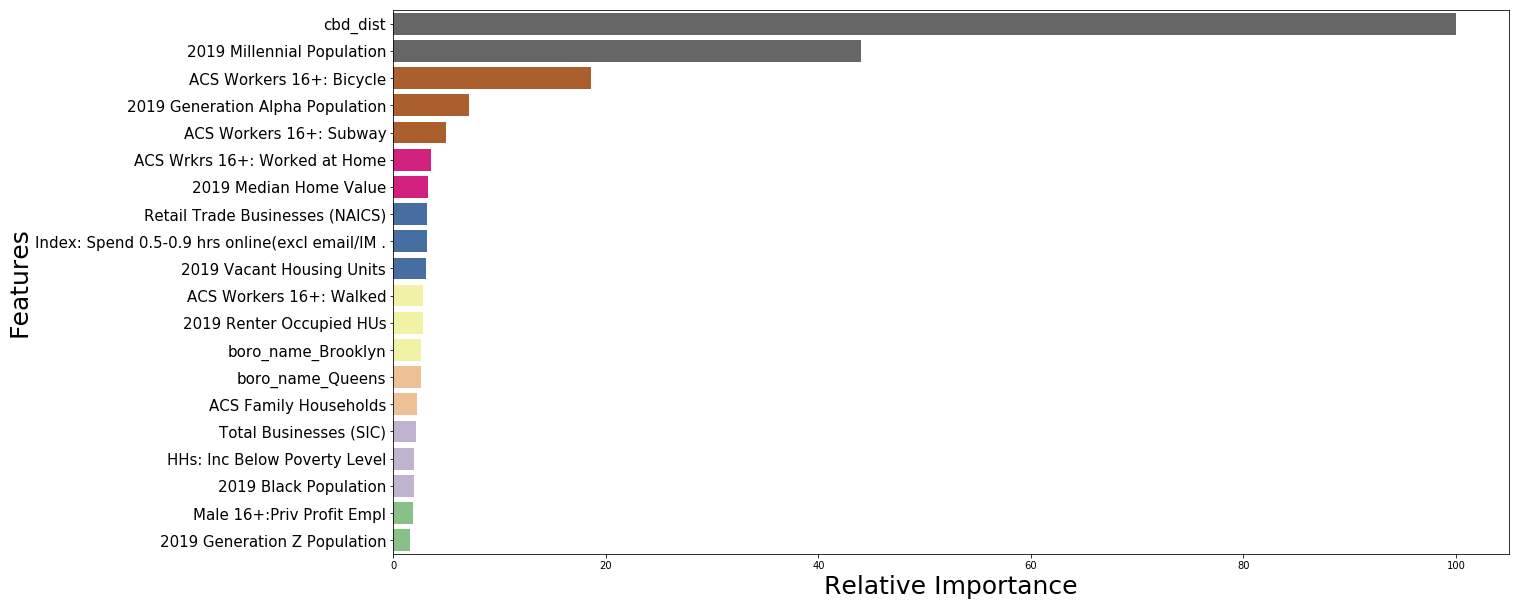

In [68]:
feature_imp_RF = model_RF.feature_importances_

#relative feature importance  
rel_feature_imp = 100 * (feature_imp_RF / max(feature_imp_RF)) 
rel_feature_imp = pd.DataFrame({'features':list(X_train.columns),
                                'rel_importance':rel_feature_imp })

rel_feature_imp = rel_feature_imp.sort_values('rel_importance', ascending=False)


#plotting the top twenty important features
top20_features = rel_feature_imp.head(20) 

plt.figure(figsize=[20,10])
plt.yticks(fontsize=15)
ax = sns.barplot(x="rel_importance", y="features",
                 data=top20_features,
                 palette="Accent_r")

plt.xlabel("Relative Importance", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.show()

In [69]:
rel_feature_imp.head()

,features,rel_importance
5,cbd_dist,100.000000
68,2019 Millennial Population,44.053143
12,ACS Workers 16+: Bicycle,18.573569
61,2019 Generation Alpha Population,7.116598
44,ACS Workers 16+: Subway,4.931776


The feature importance plot reveals that distance from the city centre (cbd_dist) is the most important predictor of the number of Airbnb formation in NYC. This is expected since hotel rents near the cbd are quite high, rental income from Airbnb properties would be high as well, hence setting up Airbnb property would be a lucrative option, compared to long term rental income in areas near the cbd.

This is followed by the number of millennial population, or the tracts having most number of people in the age group of 25 to 40 years old. One reason might be that these group of population are more active online and are comfortable with internet technologies which is in a way a necessary prerequisite for setting up Airbnb properties. This is supported by the presence of another interesting predictor variable of -- 0.5-0.9 hrs online activity, in the top twenty.

This is followed by the tracts having workers who commute by bicycle and is the third most important predictor, which is followed by the number of generation alpha population, who are person born after 2011, and then by tracts having people commuting by subway, and so on. The median home value of the tracts is also an interesting predictor.

### Gradient Boosting Regressor Model  <a class="anchor" id="645"></a>
Here trial shows that the gradient boosting model performs better with non scale data

In [70]:
# GradientBoosting with non scaled data
# this model uses the default parameters of GB algorithm, while the estimators are changed to obtain the best fit 
model_GB_nonscale = GradientBoostingRegressor(n_estimators=500, random_state=60)

# Train the model
model_GB_nonscale.fit(X_train, y_train_array)

# Training metrics for Gradient Boosting Regressor model
print('Training metrics for Gradient Boosting Regressor model using scaled data')

ypred_GB_train = model_GB_nonscale.predict(X_train)
print('r-square_GB_Train: ', round(model_GB_nonscale.score(X_train, y_train_array), 2))

mse_RF_train = metrics.mean_squared_error(y_train_array, ypred_GB_train)
print('RMSE_GB_Train: ', round(np.sqrt(mse_RF_train), 4))

mean_absolute_error_RF_train = metrics.mean_absolute_error(y_train_array, ypred_GB_train)
print('MAE_GB_Train: ', round(mean_absolute_error_RF_train, 4))

#Test metrics for Gradient Boosting Regressor model
print('\nTest metrics for Gradient Boosting Regressor model using scaled data')

ypred_GB_test = model_GB_nonscale.predict(X_test)
print('r-square_GB_Test: ', round(model_GB_nonscale.score(X_test, y_test_array),2))

mse_RF_Test = metrics.mean_squared_error(y_test_array, ypred_GB_test)  
print('RMSE_GB_Test: ', round(np.sqrt(mse_RF_Test),4))

mean_absolute_error_GB_Test = metrics.mean_absolute_error(y_test_array, ypred_GB_test)
print('MAE_GB_Test: ', round(mean_absolute_error_GB_Test, 4))

Training metrics for Gradient Boosting Regressor model using scaled data
r-square_GB_Train:  0.99
RMSE_GB_Train:  3.1854
MAE_GB_Train:  2.3426

Test metrics for Gradient Boosting Regressor model using scaled data
r-square_GB_Test:  0.88
RMSE_GB_Test:  16.2517
MAE_GB_Test:  8.6577


The result shows that the Gradient boosting regressor model is performing slightly better both in terms of Mean Absolute error and r-square than the random forest model.

### Feature Importance of Gradient Boosting Model <a class="anchor" id="647"></a>

In [71]:
#checking the feature importance for the Gradient Boosting regressor
feature_imp_GB = model_GB_nonscale.feature_importances_
rel_feature_imp_GB = 100 * feature_imp_GB / max(feature_imp_GB)
rel_feature_imp_GB = pd.DataFrame({'features':list(X_train.columns),
                                   'rel_importance':rel_feature_imp_GB})
rel_feature_imp_GB = rel_feature_imp_GB.sort_values('rel_importance', ascending=False)
rel_feature_imp_GB.head()

,features,rel_importance
5,cbd_dist,100.000000
68,2019 Millennial Population,46.725049
12,ACS Workers 16+: Bicycle,31.834925
44,ACS Workers 16+: Subway,15.586322
61,2019 Generation Alpha Population,12.891210


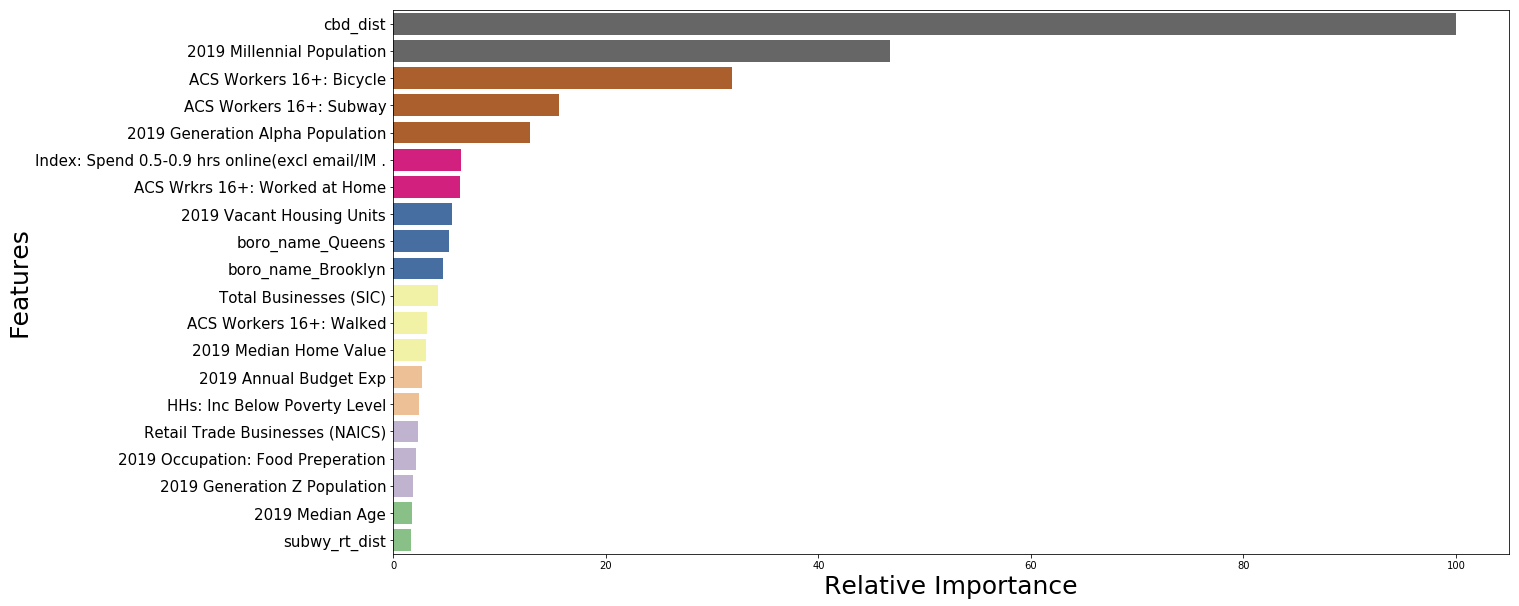

In [72]:
# Plot  feature importance for the Gradient Boosting regressor
top20_features_GB = rel_feature_imp_GB.head(20) 

plt.figure(figsize=[20,10])
plt.yticks(fontsize=15)
ax = sns.barplot(x="rel_importance", y="features", data = top20_features_GB, palette="Accent_r")
plt.xlabel("Relative Importance", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.show()

The feature importance shown by the Gradient boosting model are almost identical to the one returned by the random forest model, which is expected.

### Running cross validation <a class="anchor" id="651"></a>

The above model is fitted and accuracy measured on a particular train and test split of the data. However the model accuracy for multiple split of the data remains to be seen. This is accomplished using k fold cross validation which splits the data into k different train-test splits and fit the model for each of them. Hence a 10 fold cross validation is run to check the overall model accuracy which is measured here as the mean absolute error for model fit accross the 10 different splits.

In [73]:
# Validating with a 10 fold cross validation for the Gradient Boosting models
y_array = y.values.flatten()

modelGB_cross_val = GradientBoostingRegressor(n_estimators=500, random_state=60) 

modelGB_cross_val_scores = cross_val_score(modelGB_cross_val,
                                           X, 
                                           y_array,
                                           cv=10,
                                           scoring='neg_mean_absolute_error')

print("All Model Scores: ", modelGB_cross_val_scores)

print("Negative Mean Absolute Error: {}".format(np.mean(modelGB_cross_val_scores)))

All Model Scores:  [ -9.028579 -11.43918   -9.866992 -23.537995  -5.697105 -39.70685  -15.560179  -9.992469  -4.796929  -5.15258 ]
Negative Mean Absolute Error: -13.477885926281335


In [74]:
# Validating with a 10 fold cross validation for the Random forest models
y_array = y.values.flatten()

modelRF_cross_val = RandomForestRegressor(n_estimators=500, random_state=43)

modelRF_cross_val_scores = cross_val_score(modelRF_cross_val,
                                           X, 
                                           y_array,
                                           cv=10,
                                           scoring='neg_mean_absolute_error')

print("All Model Scores: ", modelRF_cross_val_scores)

print("Negative Mean Absolute Error: {}".format(np.mean(modelRF_cross_val_scores)))

All Model Scores:  [-11.675733  -9.465871 -11.120866 -22.958313  -4.940608 -37.30388  -18.044691 -11.955269  -5.43287   -4.168185]
Negative Mean Absolute Error: -13.706628720771466


### Final Result Visualization <a class="anchor" id="652"></a>

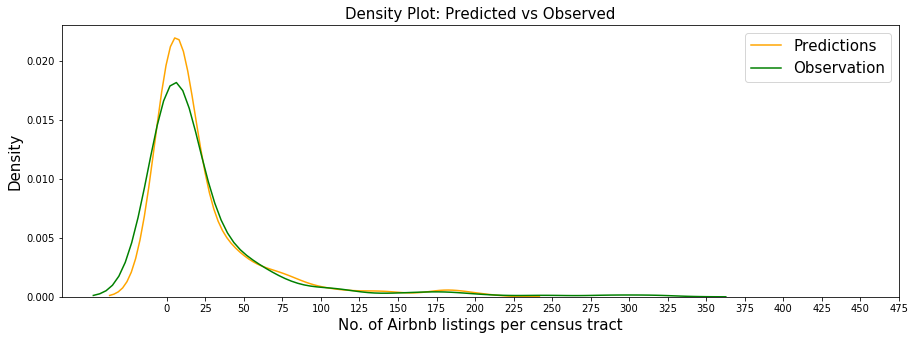

In [75]:
# Plotting a kernel density map of the predicted vs. observed data
plt.figure(figsize=[15,5])

# plotting the prediction
sns.kdeplot(ypred_RF_test, label = 'Predictions', color = 'orange')
y_observed = np.array(y_test).reshape((-1, ))
sns.kdeplot(y_observed, label = 'Observation', color = 'green')

# label the plot
plt.xlabel('No. of Airbnb listings per census tract', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Density Plot: Predicted vs Observed', fontsize=15)
plt.xticks(range(0,500,25), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)
plt.show()

In [76]:
# Converting the predicted and observed values to dataframe and plotting the observed vs predicted
y_test_df = y_test.copy()
y_test_df['Predicted'] = (ypred_RF_test)  
y_test_df.head()

,total_airbnb,Predicted
20,4,3.940
910,6,4.186
685,2,4.908
450,1,2.236
1044,2,8.422


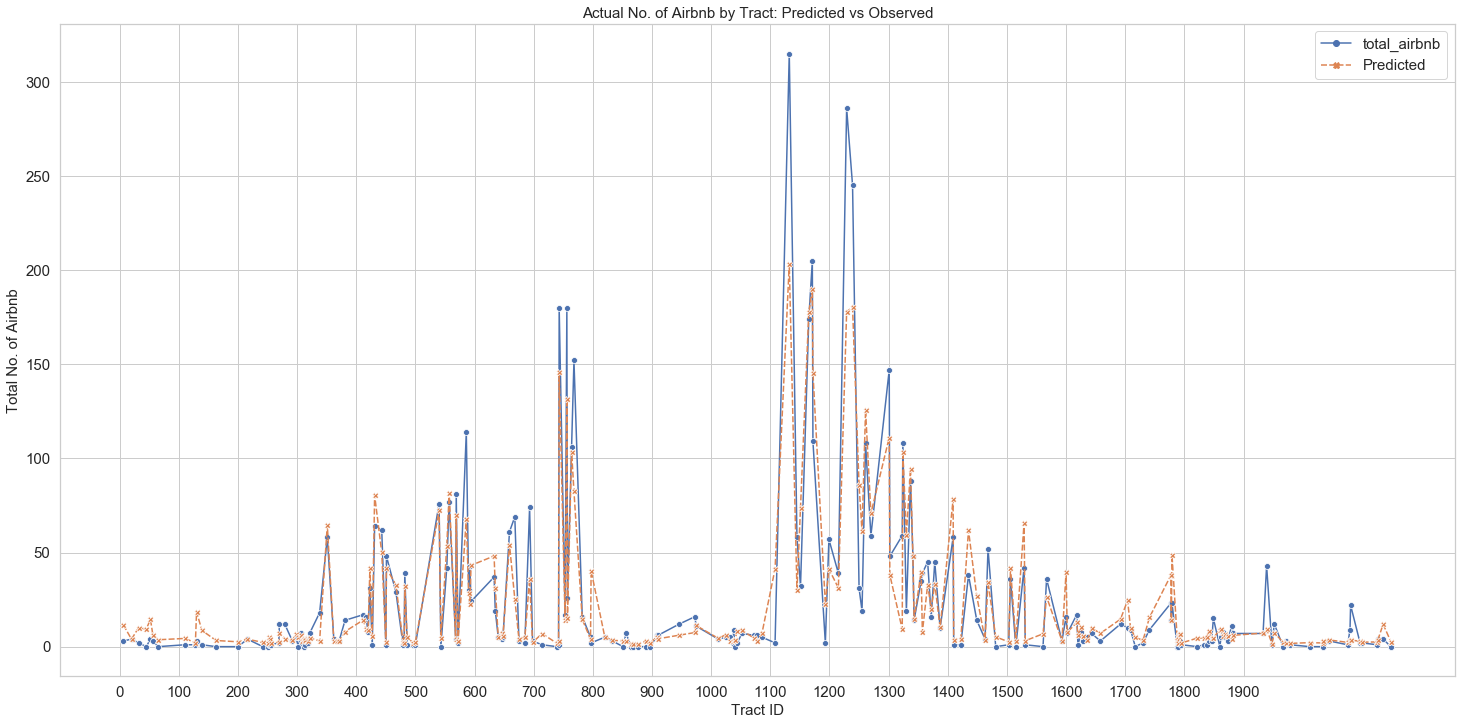

In [77]:
# plotting the actual observed vs predicted airbnb properties by tract
plt.figure(figsize = [25,12])
sns.set(style = 'whitegrid')
sns.lineplot(data = y_test_df, markers=True, hue="logic") 

#label the plot
plt.xlabel('Tract ID', fontsize=15)
plt.ylabel('Total No. of Airbnb', fontsize=15)
plt.title('Actual No. of Airbnb by Tract: Predicted vs Observed', fontsize=15)
plt.xticks(range(0,2000,100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='10')
plt.legend(fontsize=15)
plt.show()

The plot shows that the predicted values closely matches the observed values. However there are instances of underprediction for tracts with extremely high number of airbnb properties, and also overprediction instances for some tracts with comparatively lower number of airbnb properties.

### Conclusion <a class="anchor" id="655"></a>

The study shows that the location factor of distance from CBD is the foremost important factor which stimulates creation of Airbnb properties.

The proximity tool from the ArcGIS API for Python was used to perform this significant task for all the distance estimation. Other factors as returned by the feature importance result could be dealt individually. Another interesting capability of Esri utilized in the study is that of Esri's data repository, elaborated here via the geoenrichment services. The data enrichment service could provide the analyst an wide array of data that could be used for critical analysis. Further analysis would be done in the next study on this dataset.  

### Summary of methods used <a class="anchor" id="657"></a>

| Method | Question | Examples |
| -| - |-|
| aggregate_points| How many points within each polygon?  |Counting the number of airbnb rentals within each NYC tracts|
| Data Enrichment| Which demographic attribute are relevant for the problem?  |Population of Millennials for each tract|
| find_nearest| Which distances from city features are relevant for the problem?  |Distance of the CBD from each tract|

### Data resources <a class="anchor" id="656"></a>

| Shapefile | Source | Link |
| -| - |-|
| airbnb_nyc2019| NYC Airbnb Data Inside Airbnb:Get the Data  |http://insideairbnb.com/get-the-data.html|
| nyc_tract_fulll|NYC Open Data: 2010 Census Tracts (water areas included)  |https://data.cityofnewyork.us/City-Government/2010-Census-Tracts-water-areas-included-/gx7x-82rk|
| busi_distr | NYC Open Data: Business Improvement Districts  |https://data.cityofnewyork.us/Business/Business-Improvement-Districts/ejxk-d93y|
| cbd|NYC Open Data: Business Improvement Districts  |https://data.cityofnewyork.us/Business/Business-Improvement-Districts/ejxk-d93y|
| bus_stop|NYC Open Data: Bus Stop Shelters  |https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz|
| hotels|NYC Open Data: Facilities Database  |https://data.cityofnewyork.us/City-Government/Facilities-Database-Shapefile/2fpa-bnsx|
| railroad|NYC Open Data: Railroad Line  |https://data.cityofnewyork.us/Transportation/Railroad-Line/i7a5-bsik|
| subwy_rt|NYC Open Data: Subway Lines  |https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu|
| subwy_stn|NYC Open Data: Subway Stations  |https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49|
